# Problem: Forecasting Stock Prices using Machine Learning Algorithms

## Method: ANN
## Data: Stock market prices from Investing.com
## Libraries:
- numpy
- pandas
- statsmodels
- requests
- plotly

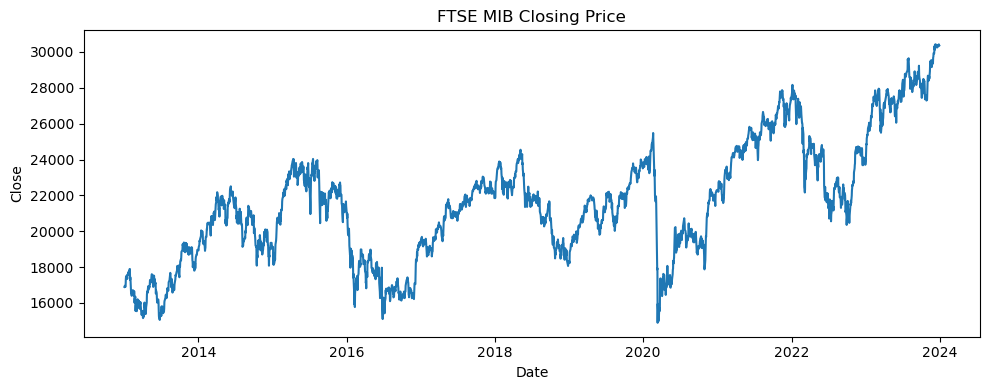

Training samples: 2188, Test samples: 562
Epoch 1/100
62/62 - 2s - 24ms/step - loss: 0.0205 - val_loss: 0.0020
Epoch 2/100
62/62 - 0s - 3ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 3/100
62/62 - 0s - 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
62/62 - 0s - 3ms/step - loss: 0.0015 - val_loss: 6.6118e-04
Epoch 5/100
62/62 - 0s - 3ms/step - loss: 0.0011 - val_loss: 6.0227e-04
Epoch 6/100
62/62 - 0s - 3ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
62/62 - 0s - 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/100
62/62 - 0s - 3ms/step - loss: 0.0010 - val_loss: 9.2316e-04
Epoch 9/100
62/62 - 0s - 4ms/step - loss: 9.7071e-04 - val_loss: 5.4608e-04
Epoch 10/100
62/62 - 0s - 3ms/step - loss: 0.0011 - val_loss: 5.5657e-04
Epoch 11/100
62/62 - 0s - 3ms/step - loss: 9.7959e-04 - val_loss: 5.6545e-04
Epoch 12/100
62/62 - 0s - 3ms/step - loss: 8.6130e-04 - val_loss: 0.0023
Epoch 13/100
62/62 - 0s - 3ms/step - loss: 0.0010 - val_loss: 4.9082e-04
Epoch 14/100
62/62 - 0s - 3ms

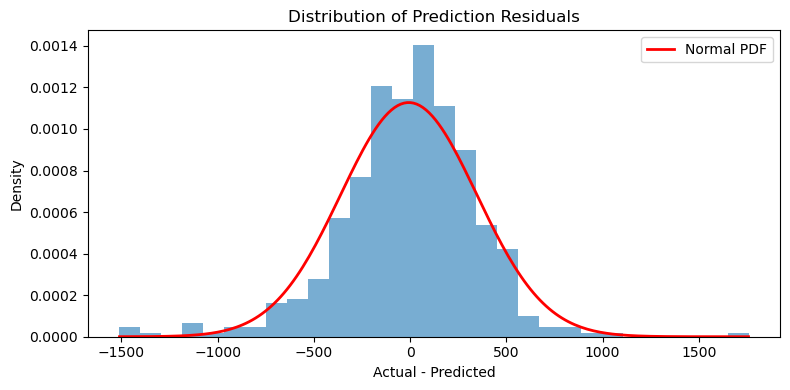

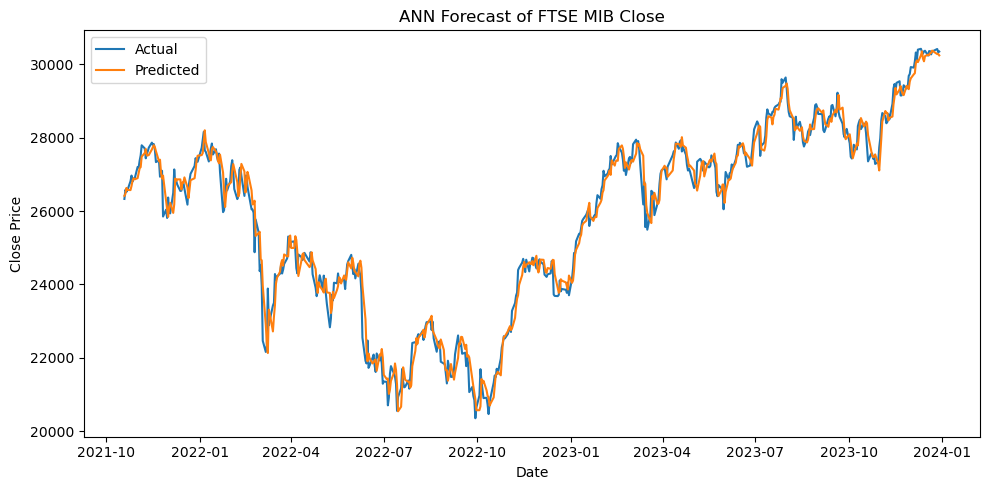

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Next day predicted close: 30325.48


In [2]:
"""Feedforward ANN forecasting of the FTSE MIB closing price.

This script loads the daily closing prices from ``dataftsemib_manual.csv``,
cleans the numeric fields, and prepares sequences of the previous 60 closes
to predict the next day's close. A simple multi-layer perceptron is trained
on the training portion (80%) and evaluated on the remaining 20%.  The script
prints RMSE, MAE, MAPE and R^2 metrics and plots the predicted vs. actual
closing prices for the test set.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from tensorflow import keras

# ----------------------------------------------------------------------------
# 1. Load and clean the dataset
# ----------------------------------------------------------------------------

FILE_PATH = "dataftsemib_manual.csv"
WINDOW = 60  # number of past days used for each prediction

# Read CSV

df = pd.read_csv(FILE_PATH)

# Parse dates (day first)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# The closing price column is named "Price". Remove commas and convert to float.
df["Price"] = df["Price"].str.replace(",", "").astype(float)

# Sort chronologically

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Plot the cleaned closing prices
plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Price"])
plt.title("FTSE MIB Closing Price")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.savefig("ann_cleaned_prices.png")
plt.show()
plt.close()

# ----------------------------------------------------------------------------
# 2. Prepare sequences for the feedforward network
# ----------------------------------------------------------------------------

prices = df["Price"].values.reshape(-1, 1)

# Scale prices between 0 and 1 using only the training portion to avoid
# information leakage.
train_split = int(len(prices) * 0.8)
price_scaler = MinMaxScaler()
price_scaler.fit(prices[:train_split])
prices_scaled = price_scaler.transform(prices)

# Build sequences of length WINDOW
def create_sequences(series: np.ndarray, dates: np.ndarray, window: int):
    """Build rolling window sequences for supervised learning."""
    X, y, d = [], [], []
    for i in range(window, len(series)):
        X.append(series[i - window:i].flatten())
        y.append(series[i, 0])
        d.append(dates[i])
    return np.array(X), np.array(y), np.array(d)

X, y, seq_dates = create_sequences(prices_scaled, df["Date"].values, WINDOW)

# Split into train/test sets
split_idx = train_split - WINDOW
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

dates_test = pd.to_datetime(seq_dates[split_idx:])

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ----------------------------------------------------------------------------
# 3. Build the feedforward ANN model
# ----------------------------------------------------------------------------

model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)  # output next day's scaled close
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Early stopping helps prevent overfitting
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

# ----------------------------------------------------------------------------
# 4. Evaluate on the test set
# ----------------------------------------------------------------------------

pred_scaled = model.predict(X_test)
pred_prices = price_scaler.inverse_transform(pred_scaled)
true_prices = price_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
mape = mean_absolute_percentage_error(true_prices, pred_prices)
r2 = r2_score(true_prices, pred_prices)
residuals = true_prices.flatten() - pred_prices.flatten()
lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb["lb_pvalue"].iloc[0]

print(
    f"Test RMSE: {rmse:.2f}\n"
    f"Test MAE: {mae:.2f}\n"
    f"Test MAPE: {mape:.2%}\n"
    f"Test R^2: {r2:.4f}\n"
    f"Residual Ljung-Box p-value (lag 10): {lb_p:.4f}"
)

# Plot residual distribution
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color="tab:blue")
x = np.linspace(residuals.min(), residuals.max(), 200)
plt.plot(x, stats.norm.pdf(x, loc=residuals.mean(), scale=residuals.std()), color="red", lw=2, label="Normal PDF")
plt.title("Distribution of Prediction Residuals")
plt.xlabel("Actual - Predicted")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("ann_residuals.png")
plt.show()

# Plot actual vs predicted closing prices
plt.figure(figsize=(10, 5))
plt.plot(dates_test, true_prices.flatten(), label="Actual")
plt.plot(dates_test, pred_prices.flatten(), label="Predicted")
plt.title("ANN Forecast of FTSE MIB Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.savefig("ann_prediction_plot.png")
plt.show()

# ----------------------------------------------------------------------------
# 5. Forecast the next day's closing price
# ----------------------------------------------------------------------------

last_window = prices_scaled[-WINDOW:].flatten().reshape(1, -1)
next_scaled = model.predict(last_window)
next_price = price_scaler.inverse_transform(next_scaled)[0, 0]
print(f"Next day predicted close: {next_price:.2f}")

# Save the trained model
model.save("ftse_mib_ann_model.h5")

# Conclusion

| Metric                | Value                        | Interpretation                                                           |
| --------------------- | ---------------------------- | ------------------------------------------------------------------------ |
| Test MAE              | 263.02                       | Lower error than LSTM, close to ARIMA; predictions within \~263 points.  |
| Test MAPE             | 1.04%                        | Relative error nearly as low as ARIMA; most predictions within 1.04%.    |
| Test R²               | 0.9805                       | Highest fit; 98.05% of variance explained—slightly best overall.         |
| Residual Mean         | ≈ 0                          | Residuals are unbiased (mean near zero).                                 |
| t-test p-value        | (not reported)               | (Not available, but histogram indicates no bias.)                        |
| Ljung-Box p-value     | 0.0000                       | Residuals show autocorrelation; some structure in data remains.          |
| Residual Distribution | Nearly normal, centered at 0 | Model errors are roughly normal; outliers similar to other models.       |
| Residuals Trend       | No trend, more autocorr.     | No bias/drift, but some autocorrelation remains.                         |
| Visual Fit            | Very close tracking          | Closely follows actual prices; strong fit, even during volatile periods. |
